# Neuromorphic speech command recognition model
We reuse an existing code sourced from  https://github.com/manuvn/SpeechCmdRecognition.git.
However, we do not use any attention mechanism in this paper.

The original code provided us with a good and readily usable infrastructure to plug in the proposed low pass RNN models.

## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [1]:
useColab=False
if useColab:
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

Using TensorFlow backend.


In [3]:
#Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=1, task = '35word')

Google Speech commands dataset version 1 already exists. Skipping download.
Converting test set WAVs to numpy files


0it [00:00, ?it/s]


Converting training set WAVs to numpy files


0it [00:00, ?it/s]


Done preparing Google Speech commands dataset version 1


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [4]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
51094
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [5]:
sr=16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
#handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

#use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

106

In [6]:
audios, classes = valGen.__getitem__(6)
classes

array([ 2, 16,  4, 13, 10, 18,  7, 12, 19, 16, 22, 33, 15, 19, 32, 11,  1,
       25, 14,  9,  4,  1, 13,  2, 14, 15, 10, 20, 18, 33,  1,  8,  1,  3,
       13, 11,  8,  6,  9, 19, 15,  6,  1, 19, 12, 12,  4,  3, 28, 32, 12,
       29, 23, 18,  2,  8,  8,  2, 16, 16, 22, 29,  9,  5])

In [7]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 0
Non-trainable params: 1,091,664
_________________________________________________________________


In [8]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(64, 80, 125, 1)

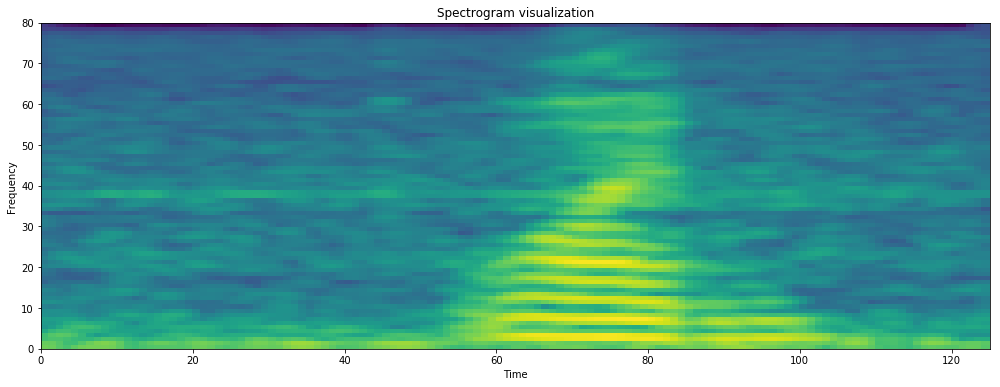

In [9]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[3,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

# Models

Create Keras models to see if the generators are working properly

In [10]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional, SimpleRNN
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers
from keras.optimizers import Adam
from kapre.time_frequency import Melspectrogram, Spectrogram
from lprnn_keras_impl import lpRNN, lpLSTM

In [11]:
#self-attention LSTM
model = SpeechModels.SimpleRNNSpeechModel(nCategs, samplingrate = sr, inputLength = iLen, rnn_model=lpRNN, nunits=128) # retention ratio not learnt
# model = SpeechModels.SimpleRNNSpeechModel(nCategs, samplingrate = sr, inputLength = iLen, rnn_model=lpLSTM, nunits=128) # retention ratio not learnt
#model = SpeechModels.SimpleRNNSpeechModel(nCategs, samplingrate = sr, inputLength = iLen, rnn_model=CuDNNLSTM, nunits=64)
#model = SpeechModels.SimpleRNNSpeechModel(nCategs, samplingrate = sr, inputLength = iLen, rnn_model=SimpleRNN, nunits=128)
#model = SpeechModels.RNNSpeechModel(nCategs, samplingrate = sr, inputLength = iLen, rnn_model=CuDNNLSTM, nunits=64)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16000)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 16000)          0         
_________________________________________________________________
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_2 (Normaliza (None, 80, 125, 1)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 125, 80, 1)        0         
_________________________________________________________________
squeeze_last_dim (Lambda)    (None, 125, 80)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 125, 128)          10368     
__________

In [12]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-simplernn_dense.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
results = model.fit_generator(trainGen, validation_data = valGen, epochs = 40, use_multiprocessing=True, workers=4,
                    callbacks=[earlystopper, checkpointer, lrate])

Epoch 1/40
Changing learning rate to 0.001
333/798 [===========>..................] - ETA: 2:02 - loss: 2.8240 - sparse_categorical_accuracy: 0.1684

In [ ]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import pickle
fname= 'simplernn.log'
pickle_out = open(fname,"wb")
pickle.dump([results.history['sparse_categorical_accuracy'], results.history['val_sparse_categorical_accuracy'], results.history['loss'], results.history['val_loss']], pickle_out)
pickle_out.close()

In [ ]:
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
logs = ['simplernn.log','lprnn_dense.log','lstm_dense.log', 'lprnn_conv.log', 'lstm_conv.log']
label = ['Simple RNN', 'lpRNN dense', 'LSTM dense', 'lpRNN Conv', 'LSTM Conv']
logs = ['simplernn.log', 'lstm_dense.log','lprnn_dense.log']
label = ['Simple RNN', 'LSTM dense', 'lpRNN dense']
colors = ['r','b','g','k']
idx = 0
legends = []
nentries = 3
for idx in range(nentries):
    acc, val_acc,_,_ = pickle.load(open( logs[idx], "rb" ))
    # summarize history for categorical accuracy
    plt.plot(acc, color=colors[idx])#results.history['sparse_categorical_accuracy'])
    plt.plot(val_acc,'--', color=colors[idx])#results.history['val_sparse_categorical_accuracy'])
    #legends = legends + ['Train: '+ label[idx]]
    legends = legends + [r'Train: '+ label[idx] +f': {acc[-1]:.2f}', r'Val: '+ label[idx] +f': {val_acc[-1]:.2f}']

plt.legend(legends)#, loc='upper left')
plt.title(r'Categorical accuracy - Train')
plt.ylabel(r'Accuracy')
plt.xlabel(r'Epoch')
plt.savefig('google_acc.pdf',dpi=500)
plt.show()



idx = 0
legends = []
for idx in range(nentries):
    _,_, loss, val_loss = pickle.load(open( logs[idx], "rb" ))
    # summarize history for categorical accuracy
    plt.plot(loss, color=colors[idx])
    plt.plot(val_loss,'--', color=colors[idx])
    #legends = legends + ['Train: '+ label[idx]]
    legends = legends + ['Train: '+ label[idx]  +f': {loss[-1]:.2f}', 'Val: '+ label[idx] +f': {val_loss[-1]:.2f}']

plt.legend(legends)#, loc='upper left')
plt.title(r'Categorical cross entropy loss - Train')
plt.ylabel(r'Loss')
plt.xlabel(r'Epoch')
plt.savefig('google_loss.pdf',dpi=500)
plt.show()